In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)

import xgboost as xgb
from xgboost import XGBClassifier


## Cleaning

In [3]:
df = pd.read_csv(
    r"/kaggle/input/nasa-exoplanet-prediction/k2pandc_2025.10.03_05.54.41.csv",
    skiprows=98   # remove descriptive rows (first 94)
)

df.head()

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1,1,Transit,2016,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2018-03,2018-02-15
1,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1,1,Transit,2016,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2016-10,2016-07-28
2,BD+20 594 b,BD+20 594,1,CONFIRMED,Espinoza et al. 2016,1,1,Transit,2016,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2017-03,2018-04-26
3,EPIC 201111557.01,EPIC 201111557,1,CANDIDATE,Livingston et al. 2018,1,0,Transit,2018,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-08-02,2018-08,2018-08-02
4,EPIC 201111557.01,EPIC 201111557,0,CANDIDATE,Livingston et al. 2018,1,0,Transit,2018,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-02-15,2018-03,2018-02-15


In [4]:
df.columns.to_list()

['pl_name',
 'hostname',
 'default_flag',
 'disposition',
 'disp_refname',
 'sy_snum',
 'sy_pnum',
 'discoverymethod',
 'disc_year',
 'disc_facility',
 'soltype',
 'pl_controv_flag',
 'pl_refname',
 'pl_orbper',
 'pl_orbpererr1',
 'pl_orbpererr2',
 'pl_orbperlim',
 'pl_orbsmax',
 'pl_orbsmaxerr1',
 'pl_orbsmaxerr2',
 'pl_orbsmaxlim',
 'pl_rade',
 'pl_radeerr1',
 'pl_radeerr2',
 'pl_radelim',
 'pl_radj',
 'pl_radjerr1',
 'pl_radjerr2',
 'pl_radjlim',
 'pl_bmasse',
 'pl_bmasseerr1',
 'pl_bmasseerr2',
 'pl_bmasselim',
 'pl_bmassj',
 'pl_bmassjerr1',
 'pl_bmassjerr2',
 'pl_bmassjlim',
 'pl_bmassprov',
 'pl_orbeccen',
 'pl_orbeccenerr1',
 'pl_orbeccenerr2',
 'pl_orbeccenlim',
 'pl_insol',
 'pl_insolerr1',
 'pl_insolerr2',
 'pl_insollim',
 'pl_eqt',
 'pl_eqterr1',
 'pl_eqterr2',
 'pl_eqtlim',
 'ttv_flag',
 'st_refname',
 'st_spectype',
 'st_teff',
 'st_tefferr1',
 'st_tefferr2',
 'st_tefflim',
 'st_rad',
 'st_raderr1',
 'st_raderr2',
 'st_radlim',
 'st_mass',
 'st_masserr1',
 'st_masserr2',


In [5]:
df.isnull().sum()

pl_name            0
hostname           0
default_flag       0
disposition        0
disp_refname       0
                  ..
sy_gaiamagerr1    56
sy_gaiamagerr2    56
rowupdate          0
pl_pubdate         0
releasedate        0
Length: 94, dtype: int64

In [6]:
# Count missing values
missing_count = df.isnull().sum()

# Percentage of missing values
missing_percentage = (missing_count / len(df)) * 100

# Combine into one DataFrame
missing_summary = pd.DataFrame({
    'Missing Values': missing_count,
    'Percentage (%)': missing_percentage
})

# Show all columns
pd.set_option("display.max_rows", None)   # show all rows
pd.set_option("display.max_columns", None)

print(missing_summary)


                 Missing Values  Percentage (%)
pl_name                       0        0.000000
hostname                      0        0.000000
default_flag                  0        0.000000
disposition                   0        0.000000
disp_refname                  0        0.000000
sy_snum                       0        0.000000
sy_pnum                       0        0.000000
discoverymethod               0        0.000000
disc_year                     0        0.000000
disc_facility                 0        0.000000
soltype                       0        0.000000
pl_controv_flag               0        0.000000
pl_refname                    0        0.000000
pl_orbper                    44        1.098901
pl_orbpererr1               933       23.301698
pl_orbpererr2               933       23.301698
pl_orbperlim                 44        1.098901
pl_orbsmax                 3184       79.520480
pl_orbsmaxerr1             3191       79.695305
pl_orbsmaxerr2             3191       79

In [7]:
# Step 1: Handle Missing Values
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna("Unknown")

In [8]:
df.isnull().sum()

pl_name            0
hostname           0
default_flag       0
disposition        0
disp_refname       0
sy_snum            0
sy_pnum            0
discoverymethod    0
disc_year          0
disc_facility      0
soltype            0
pl_controv_flag    0
pl_refname         0
pl_orbper          0
pl_orbpererr1      0
pl_orbpererr2      0
pl_orbperlim       0
pl_orbsmax         0
pl_orbsmaxerr1     0
pl_orbsmaxerr2     0
pl_orbsmaxlim      0
pl_rade            0
pl_radeerr1        0
pl_radeerr2        0
pl_radelim         0
pl_radj            0
pl_radjerr1        0
pl_radjerr2        0
pl_radjlim         0
pl_bmasse          0
pl_bmasseerr1      0
pl_bmasseerr2      0
pl_bmasselim       0
pl_bmassj          0
pl_bmassjerr1      0
pl_bmassjerr2      0
pl_bmassjlim       0
pl_bmassprov       0
pl_orbeccen        0
pl_orbeccenerr1    0
pl_orbeccenerr2    0
pl_orbeccenlim     0
pl_insol           0
pl_insolerr1       0
pl_insolerr2       0
pl_insollim        0
pl_eqt             0
pl_eqterr1   

In [9]:
# Step 2: Check Duplicates
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()

Duplicate rows: 0


In [10]:
# Step 3: Standardize Categorical Columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip().str.upper()

In [11]:
df.columns.to_list()

['pl_name',
 'hostname',
 'default_flag',
 'disposition',
 'disp_refname',
 'sy_snum',
 'sy_pnum',
 'discoverymethod',
 'disc_year',
 'disc_facility',
 'soltype',
 'pl_controv_flag',
 'pl_refname',
 'pl_orbper',
 'pl_orbpererr1',
 'pl_orbpererr2',
 'pl_orbperlim',
 'pl_orbsmax',
 'pl_orbsmaxerr1',
 'pl_orbsmaxerr2',
 'pl_orbsmaxlim',
 'pl_rade',
 'pl_radeerr1',
 'pl_radeerr2',
 'pl_radelim',
 'pl_radj',
 'pl_radjerr1',
 'pl_radjerr2',
 'pl_radjlim',
 'pl_bmasse',
 'pl_bmasseerr1',
 'pl_bmasseerr2',
 'pl_bmasselim',
 'pl_bmassj',
 'pl_bmassjerr1',
 'pl_bmassjerr2',
 'pl_bmassjlim',
 'pl_bmassprov',
 'pl_orbeccen',
 'pl_orbeccenerr1',
 'pl_orbeccenerr2',
 'pl_orbeccenlim',
 'pl_insol',
 'pl_insolerr1',
 'pl_insolerr2',
 'pl_insollim',
 'pl_eqt',
 'pl_eqterr1',
 'pl_eqterr2',
 'pl_eqtlim',
 'ttv_flag',
 'st_refname',
 'st_spectype',
 'st_teff',
 'st_tefferr1',
 'st_tefferr2',
 'st_tefflim',
 'st_rad',
 'st_raderr1',
 'st_raderr2',
 'st_radlim',
 'st_mass',
 'st_masserr1',
 'st_masserr2',


In [12]:
# Step 4: Validate Numerical Ranges (example checks)
df = df[df["pl_orbper"] > 0]     # orbital period > 0
df = df[df["pl_rade"] > 0]       # planet radius > 0
if "koi_impact" in df.columns:
    df = df[(df["koi_impact"] >= 0) & (df["koi_impact"] <= 1)]

In [13]:
# Step 5: Convert Scientific Notation
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [14]:
# Step 6: Format Dates/Times (example: convert BJD to datetime if exists)
if "koi_time0bk" in df.columns:
    df["koi_time0bk_converted"] = pd.to_datetime(
        df["koi_time0bk"], errors="coerce", origin="julian", unit="D"
    )

In [15]:
# Step 7: Remove Unnecessary Columns
drop_cols = ["pl_name", "hostname", "ra", "dec", "sy_refname", "disp_refname"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [16]:
# Step 8: Drop columns with >70% missing values
missing_ratio = df.isnull().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.7].index
df = df.drop(columns=high_missing_cols)

print("Dropped columns:", list(high_missing_cols))
print("Remaining shape:", df.shape)

Dropped columns: []
Remaining shape: (4004, 88)


In [17]:
# Step 9: Drop columns with >50% missing OR irrelevant identifiers
missing_ratio = df.isnull().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.5].index

id_cols = ["pl_name", "hostname", "sy_refname", "disp_refname", "rowupdate", "pl_pubdate"]

drop_cols = set(high_missing_cols).union(id_cols)
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("Dropped:", len(drop_cols), "columns")
print("Remaining shape:", df.shape)

Dropped: 6 columns
Remaining shape: (4004, 86)


In [18]:
#remove more columns

# Columns to always drop (IDs, references, metadata)
drop_always = [
    "pl_name", "hostname", "disp_refname", "pl_refname", "st_refname", "sy_refname",
    "rowupdate", "pl_pubdate", "releasedate", "rastr", "decstr",
    "default_flag", "pl_controv_flag", "pl_bmassprov", "ttv_flag"
]

# Drop all columns that are error bounds or limits
drop_errors_limits = [c for c in df.columns if c.endswith(("err1", "err2", "lim"))]

# Define core features to keep
keep_features = [
    "disposition",              # target
    "discoverymethod", "disc_year", "disc_facility", "soltype",  # discovery info
    "sy_snum", "sy_pnum", "sy_dist",                             # system info
    "pl_orbper", "pl_orbsmax", "pl_rade", "pl_radj", "pl_bmasse", "pl_bmassj",
    "pl_orbeccen", "pl_insol", "pl_eqt",                         # planet features
    "st_spectype", "st_teff", "st_rad", "st_mass", "st_met", "st_logg", # star features
]

# Drop everything not in keep_features
df_reduced = df.drop(
    columns=[c for c in df.columns if c not in keep_features]
)

print("Original shape:", df.shape)
print("Reduced shape:", df_reduced.shape)
print("Remaining columns:", list(df_reduced.columns))


Original shape: (4004, 86)
Reduced shape: (4004, 23)
Remaining columns: ['disposition', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_spectype', 'st_teff', 'st_rad', 'st_mass', 'st_met', 'st_logg', 'sy_dist']


## Preprocessing

In [19]:
# Convert categoricals and numerics
for col in ["discoverymethod", "disc_facility", "soltype", "st_spectype"]:
    df_reduced[col] = df_reduced[col].astype("category")

# Ensure numerics are floats
num_cols = df_reduced.select_dtypes(include=["int64", "float64"]).columns
df_reduced[num_cols] = df_reduced[num_cols].apply(pd.to_numeric, errors="coerce")

df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   disposition      4004 non-null   object  
 1   sy_snum          4004 non-null   int64   
 2   sy_pnum          4004 non-null   int64   
 3   discoverymethod  4004 non-null   category
 4   disc_year        4004 non-null   int64   
 5   disc_facility    4004 non-null   category
 6   soltype          4004 non-null   category
 7   pl_orbper        4004 non-null   float64 
 8   pl_orbsmax       4004 non-null   float64 
 9   pl_rade          4004 non-null   float64 
 10  pl_radj          4004 non-null   float64 
 11  pl_bmasse        4004 non-null   float64 
 12  pl_bmassj        4004 non-null   float64 
 13  pl_orbeccen      4004 non-null   float64 
 14  pl_insol         4004 non-null   float64 
 15  pl_eqt           4004 non-null   float64 
 16  st_spectype      4004 non-null   category


In [20]:
# Scaling / Normalization
from sklearn.preprocessing import StandardScaler

scale_cols = ["pl_orbper", "pl_orbsmax", "pl_rade", "pl_radj", 
              "pl_bmasse", "pl_bmassj", "pl_orbeccen", 
              "pl_insol", "pl_eqt", "st_teff", "st_rad", 
              "st_mass", "st_met", "st_logg", "sy_dist"]

scaler = StandardScaler()
df_reduced[scale_cols] = scaler.fit_transform(df_reduced[scale_cols])


In [21]:
# Log Transformation

# Apply log1p (log(1+x)) to skewed columns
for col in ["pl_insol", "pl_orbper", "pl_orbsmax"]:
    df_reduced[col] = np.log1p(df_reduced[col])

In [22]:
# Train/Test Split

from sklearn.model_selection import train_test_split

X = df_reduced.drop(columns=["disposition"])
y = df_reduced["disposition"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (3203, 22) Test shape: (801, 22)


In [23]:
# Encode Target Variable

# Map disposition: CONFIRMED = 1, everything else = 0
y_train = y_train.apply(lambda x: 1 if x == "CONFIRMED" else 0)
y_test = y_test.apply(lambda x: 1 if x == "CONFIRMED" else 0)

print(y_train.value_counts())
print(y_test.value_counts())

disposition
1    1852
0    1351
Name: count, dtype: int64
disposition
1    463
0    338
Name: count, dtype: int64


In [24]:
# Outlier handling

# Cap at 99th percentile for numeric features
for col in scale_cols:
    cap = df_reduced[col].quantile(0.99)
    df_reduced[col] = np.where(df_reduced[col] > cap, cap, df_reduced[col])

In [25]:
print(df_reduced.shape)

(4004, 23)


In [26]:
df_reduced.head()

,disposition,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_orbeccen,pl_insol,pl_eqt,st_spectype,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist
0,CONFIRMED,1,1,TRANSIT,2016,K2,PUBLISHED CONFIRMED,0.001345,-0.062625,-0.182290,-0.182132,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,0.500943,-0.088690,0.283600,-0.279662,-0.317751,-0.387765
1,CONFIRMED,1,1,TRANSIT,2016,K2,PUBLISHED CONFIRMED,0.001343,0.687356,-0.186967,-0.186803,-0.078018,-0.078019,-1.640278,-0.125674,-1.355031,G,0.561023,-0.100582,0.274330,-0.883943,0.168746,-0.387765
2,CONFIRMED,1,1,TRANSIT,2016,K2,PUBLISHED CONFIRMED,0.001343,-0.062625,-0.173991,-0.173843,-0.024237,-0.024237,-1.640278,-0.125674,-0.100590,UNKNOWN,0.561023,-0.036308,2.344868,-0.883943,0.168746,-0.387765
3,CANDIDATE,1,0,TRANSIT,2018,K2,PUBLISHED CANDIDATE,-0.028557,-0.062625,-0.228349,-0.228139,-0.115994,-0.115994,-0.100630,-0.125674,1.067995,UNKNOWN,-0.535184,-0.170521,-0.474175,-0.078235,0.317898,-0.541380
4,CANDIDATE,1,0,TRANSIT,2018,K2,PUBLISHED CANDIDATE,-0.028557,-0.062625,-0.221169,-0.219751,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,-0.436500,-0.192343,0.011867,-0.279662,0.168746,-0.541380


In [27]:
print(df_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   disposition      4004 non-null   object  
 1   sy_snum          4004 non-null   int64   
 2   sy_pnum          4004 non-null   int64   
 3   discoverymethod  4004 non-null   category
 4   disc_year        4004 non-null   int64   
 5   disc_facility    4004 non-null   category
 6   soltype          4004 non-null   category
 7   pl_orbper        4004 non-null   float64 
 8   pl_orbsmax       4004 non-null   float64 
 9   pl_rade          4004 non-null   float64 
 10  pl_radj          4004 non-null   float64 
 11  pl_bmasse        4004 non-null   float64 
 12  pl_bmassj        4004 non-null   float64 
 13  pl_orbeccen      4004 non-null   float64 
 14  pl_insol         4004 non-null   float64 
 15  pl_eqt           4004 non-null   float64 
 16  st_spectype      4004 non-null   category


## Feature Engineering

In [28]:
# 2. Star Radius × Planet Radius
df_reduced["star_planet_size"] = df_reduced["st_rad"] * df_reduced["pl_rade"]

In [29]:
# 3. Planet–Star Temperature Difference
df_reduced["temp_diff"] = df_reduced["st_teff"] - df_reduced["pl_eqt"]

In [30]:
# 4. Log Insolation Flux
df_reduced["log_insol"] = np.log10(df_reduced["pl_insol"].replace(0, np.nan))

In [31]:
# 7. Aggregate by system (sy_pnum, sy_snum) – adds some system-level signals
df_reduced["planets_per_system"] = df_reduced["sy_pnum"]
df_reduced["stars_in_system"] = df_reduced["sy_snum"]

In [32]:
df_reduced.columns.to_list()

['disposition',
 'sy_snum',
 'sy_pnum',
 'discoverymethod',
 'disc_year',
 'disc_facility',
 'soltype',
 'pl_orbper',
 'pl_orbsmax',
 'pl_rade',
 'pl_radj',
 'pl_bmasse',
 'pl_bmassj',
 'pl_orbeccen',
 'pl_insol',
 'pl_eqt',
 'st_spectype',
 'st_teff',
 'st_rad',
 'st_mass',
 'st_met',
 'st_logg',
 'sy_dist',
 'star_planet_size',
 'temp_diff',
 'log_insol',
 'planets_per_system',
 'stars_in_system']

In [33]:
df_reduced.shape

(4004, 28)

In [34]:
df_reduced.head(25)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,disposition,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_orbeccen,pl_insol,pl_eqt,st_spectype,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,star_planet_size,temp_diff,log_insol,planets_per_system,stars_in_system
0,CONFIRMED,1,1,TRANSIT,2016,K2,PUBLISHED CONFIRMED,0.001345,-0.062625,-0.182290,-0.182132,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,0.500943,-0.088690,0.283600,-0.279662,-0.317751,-0.387765,0.016167,0.601534,NaN,1,1
1,CONFIRMED,1,1,TRANSIT,2016,K2,PUBLISHED CONFIRMED,0.001343,0.687356,-0.186967,-0.186803,-0.078018,-0.078019,-1.640278,-0.125674,-1.355031,G,0.561023,-0.100582,0.274330,-0.883943,0.168746,-0.387765,0.018805,1.916055,NaN,1,1
2,CONFIRMED,1,1,TRANSIT,2016,K2,PUBLISHED CONFIRMED,0.001343,-0.062625,-0.173991,-0.173843,-0.024237,-0.024237,-1.640278,-0.125674,-0.100590,UNKNOWN,0.561023,-0.036308,2.344868,-0.883943,0.168746,-0.387765,0.006317,0.661614,NaN,1,1
3,CANDIDATE,1,0,TRANSIT,2018,K2,PUBLISHED CANDIDATE,-0.028557,-0.062625,-0.228349,-0.228139,-0.115994,-0.115994,-0.100630,-0.125674,1.067995,UNKNOWN,-0.535184,-0.170521,-0.474175,-0.078235,0.317898,-0.541380,0.038938,-1.603179,NaN,0,1
4,CANDIDATE,1,0,TRANSIT,2018,K2,PUBLISHED CANDIDATE,-0.028557,-0.062625,-0.221169,-0.219751,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,-0.436500,-0.192343,0.011867,-0.279662,0.168746,-0.541380,0.042540,-0.335909,NaN,0,1
5,CANDIDATE,1,0,TRANSIT,2016,K2,PUBLISHED CANDIDATE,-0.029411,-0.062625,-0.113896,-0.113827,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,-1.200378,-0.251963,0.011867,0.056050,0.130231,-0.181279,0.028698,-1.099787,NaN,0,1
6,CANDIDATE,1,0,TRANSIT,2018,K2,PUBLISHED CANDIDATE,-0.025574,-0.062625,0.099449,0.097428,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,-0.155172,-0.159156,0.011867,1.734608,0.857950,-0.503062,-0.015828,-0.054581,NaN,0,1
7,CANDIDATE,1,0,TRANSIT,2018,K2,PUBLISHED CANDIDATE,-0.025574,-0.062625,0.059462,0.059450,-0.115994,-0.115994,-0.100630,-0.125674,-0.277071,UNKNOWN,-0.437186,-0.133804,-0.389928,1.553324,-0.000190,-0.503062,-0.007956,-0.160116,NaN,0,1
8,CANDIDATE,1,0,TRANSIT,2019,K2,PUBLISHED CANDIDATE,-0.029425,-0.062625,-0.238042,-0.237696,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,0.109945,-0.362327,0.011867,0.056050,0.130231,-0.411805,0.086249,0.210535,NaN,0,1
9,CANDIDATE,1,0,TRANSIT,2019,K2,PUBLISHED CANDIDATE,-0.022108,-0.062625,-0.216046,-0.215995,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,0.109945,-0.244351,0.011867,0.056050,0.130231,-0.326473,0.052791,0.210535,NaN,0,1


In [35]:
# Drop soltype column
df_reduced = df_reduced.drop(columns=["soltype"])

print("Shape after dropping soltype:", df_reduced.shape)
print("Remaining columns:", df_reduced.columns.tolist())

Shape after dropping soltype: (4004, 27)
Remaining columns: ['disposition', 'sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_spectype', 'st_teff', 'st_rad', 'st_mass', 'st_met', 'st_logg', 'sy_dist', 'star_planet_size', 'temp_diff', 'log_insol', 'planets_per_system', 'stars_in_system']


In [36]:
df_reduced.head(20)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,disposition,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_radj,pl_bmasse,pl_bmassj,pl_orbeccen,pl_insol,pl_eqt,st_spectype,st_teff,st_rad,st_mass,st_met,st_logg,sy_dist,star_planet_size,temp_diff,log_insol,planets_per_system,stars_in_system
0,CONFIRMED,1,1,TRANSIT,2016,K2,0.001345,-0.062625,-0.182290,-0.182132,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,0.500943,-0.088690,0.283600,-0.279662,-0.317751,-0.387765,0.016167,0.601534,NaN,1,1
1,CONFIRMED,1,1,TRANSIT,2016,K2,0.001343,0.687356,-0.186967,-0.186803,-0.078018,-0.078019,-1.640278,-0.125674,-1.355031,G,0.561023,-0.100582,0.274330,-0.883943,0.168746,-0.387765,0.018805,1.916055,NaN,1,1
2,CONFIRMED,1,1,TRANSIT,2016,K2,0.001343,-0.062625,-0.173991,-0.173843,-0.024237,-0.024237,-1.640278,-0.125674,-0.100590,UNKNOWN,0.561023,-0.036308,2.344868,-0.883943,0.168746,-0.387765,0.006317,0.661614,NaN,1,1
3,CANDIDATE,1,0,TRANSIT,2018,K2,-0.028557,-0.062625,-0.228349,-0.228139,-0.115994,-0.115994,-0.100630,-0.125674,1.067995,UNKNOWN,-0.535184,-0.170521,-0.474175,-0.078235,0.317898,-0.541380,0.038938,-1.603179,NaN,0,1
4,CANDIDATE,1,0,TRANSIT,2018,K2,-0.028557,-0.062625,-0.221169,-0.219751,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,-0.436500,-0.192343,0.011867,-0.279662,0.168746,-0.541380,0.042540,-0.335909,NaN,0,1
5,CANDIDATE,1,0,TRANSIT,2016,K2,-0.029411,-0.062625,-0.113896,-0.113827,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,-1.200378,-0.251963,0.011867,0.056050,0.130231,-0.181279,0.028698,-1.099787,NaN,0,1
6,CANDIDATE,1,0,TRANSIT,2018,K2,-0.025574,-0.062625,0.099449,0.097428,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,-0.155172,-0.159156,0.011867,1.734608,0.857950,-0.503062,-0.015828,-0.054581,NaN,0,1
7,CANDIDATE,1,0,TRANSIT,2018,K2,-0.025574,-0.062625,0.059462,0.059450,-0.115994,-0.115994,-0.100630,-0.125674,-0.277071,UNKNOWN,-0.437186,-0.133804,-0.389928,1.553324,-0.000190,-0.503062,-0.007956,-0.160116,NaN,0,1
8,CANDIDATE,1,0,TRANSIT,2019,K2,-0.029425,-0.062625,-0.238042,-0.237696,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,0.109945,-0.362327,0.011867,0.056050,0.130231,-0.411805,0.086249,0.210535,NaN,0,1
9,CANDIDATE,1,0,TRANSIT,2019,K2,-0.022108,-0.062625,-0.216046,-0.215995,-0.115994,-0.115994,-0.100630,-0.125674,-0.100590,UNKNOWN,0.109945,-0.244351,0.011867,0.056050,0.130231,-0.326473,0.052791,0.210535,NaN,0,1


In [37]:
for col in ["discoverymethod", "disc_facility", "st_spectype"]:
    print(col, df_reduced[col].nunique())

discoverymethod 3
disc_facility 10
st_spectype 83


In [38]:
# check missing values count and percentage in st_spectype
missing_count = df['st_spectype'].isna().sum()
total_count = len(df)
missing_percentage = (missing_count / total_count) * 100

print(f"Missing values in st_spectype: {missing_count} ({missing_percentage:.2f}%)")

Missing values in st_spectype: 0 (0.00%)


In [39]:
print("Unique values (including NaN):", df['st_spectype'].nunique(dropna=False))

Unique values (including NaN): 83


In [40]:
# Drop st_spectype column
df_reduced = df_reduced.drop(columns=["st_spectype"])

df_reduced.shape

(4004, 26)

In [41]:
# Frequency count of disc_facility categories
print(df_reduced["disc_facility"].value_counts())

disc_facility
K2                                              3799
SUPERWASP                                         66
MULTIPLE OBSERVATORIES                            30
LA SILLA OBSERVATORY                              28
HATSOUTH                                          26
HATNET                                            21
SUPERWASP-SOUTH                                   17
QATAR                                             13
CHARACTERISING EXOPLANETS SATELLITE (CHEOPS)       2
ROQUE DE LOS MUCHACHOS OBSERVATORY                 2
Name: count, dtype: int64


In [42]:
# Drop 'disc_facility'
df_reduced = df_reduced.drop(columns=["disc_facility"])

In [43]:
# One-hot encode discoverymethod
df_encoded = pd.get_dummies(df_reduced, columns=["discoverymethod"], drop_first=False)

# Check new shape + columns
print("Shape after encoding:", df_encoded.shape)
print("New columns added:", [col for col in df_encoded.columns if "discoverymethod" in col])


Shape after encoding: (4004, 27)
New columns added: ['discoverymethod_MICROLENSING', 'discoverymethod_RADIAL VELOCITY', 'discoverymethod_TRANSIT']


In [44]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   disposition                      4004 non-null   object 
 1   sy_snum                          4004 non-null   int64  
 2   sy_pnum                          4004 non-null   int64  
 3   disc_year                        4004 non-null   int64  
 4   pl_orbper                        4004 non-null   float64
 5   pl_orbsmax                       4004 non-null   float64
 6   pl_rade                          4004 non-null   float64
 7   pl_radj                          4004 non-null   float64
 8   pl_bmasse                        4004 non-null   float64
 9   pl_bmassj                        4004 non-null   float64
 10  pl_orbeccen                      4004 non-null   float64
 11  pl_insol                         4004 non-null   float64
 12  pl_eqt              

In [45]:
# Basic statistical summary
print(df_encoded.describe(include="all"))

       disposition      sy_snum      sy_pnum    disc_year    pl_orbper  \
count         4004  4004.000000  4004.000000  4004.000000  4004.000000   
unique           4          NaN          NaN          NaN          NaN   
top      CONFIRMED          NaN          NaN          NaN          NaN   
freq          2315          NaN          NaN          NaN          NaN   
mean           NaN     1.053197     1.126374  2017.547203    -0.022451   
std            NaN     0.255672     1.380610     2.031360     0.008275   
min            NaN     1.000000     0.000000  2011.000000    -0.030197   
25%            NaN     1.000000     0.000000  2016.000000    -0.028117   
50%            NaN     1.000000     1.000000  2018.000000    -0.025144   
75%            NaN     1.000000     2.000000  2018.000000    -0.019686   
max            NaN     3.000000     7.000000  2025.000000     0.014836   

         pl_orbsmax      pl_rade      pl_radj    pl_bmasse    pl_bmassj  \
count   4004.000000  4004.000000  40

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


## Correlation

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


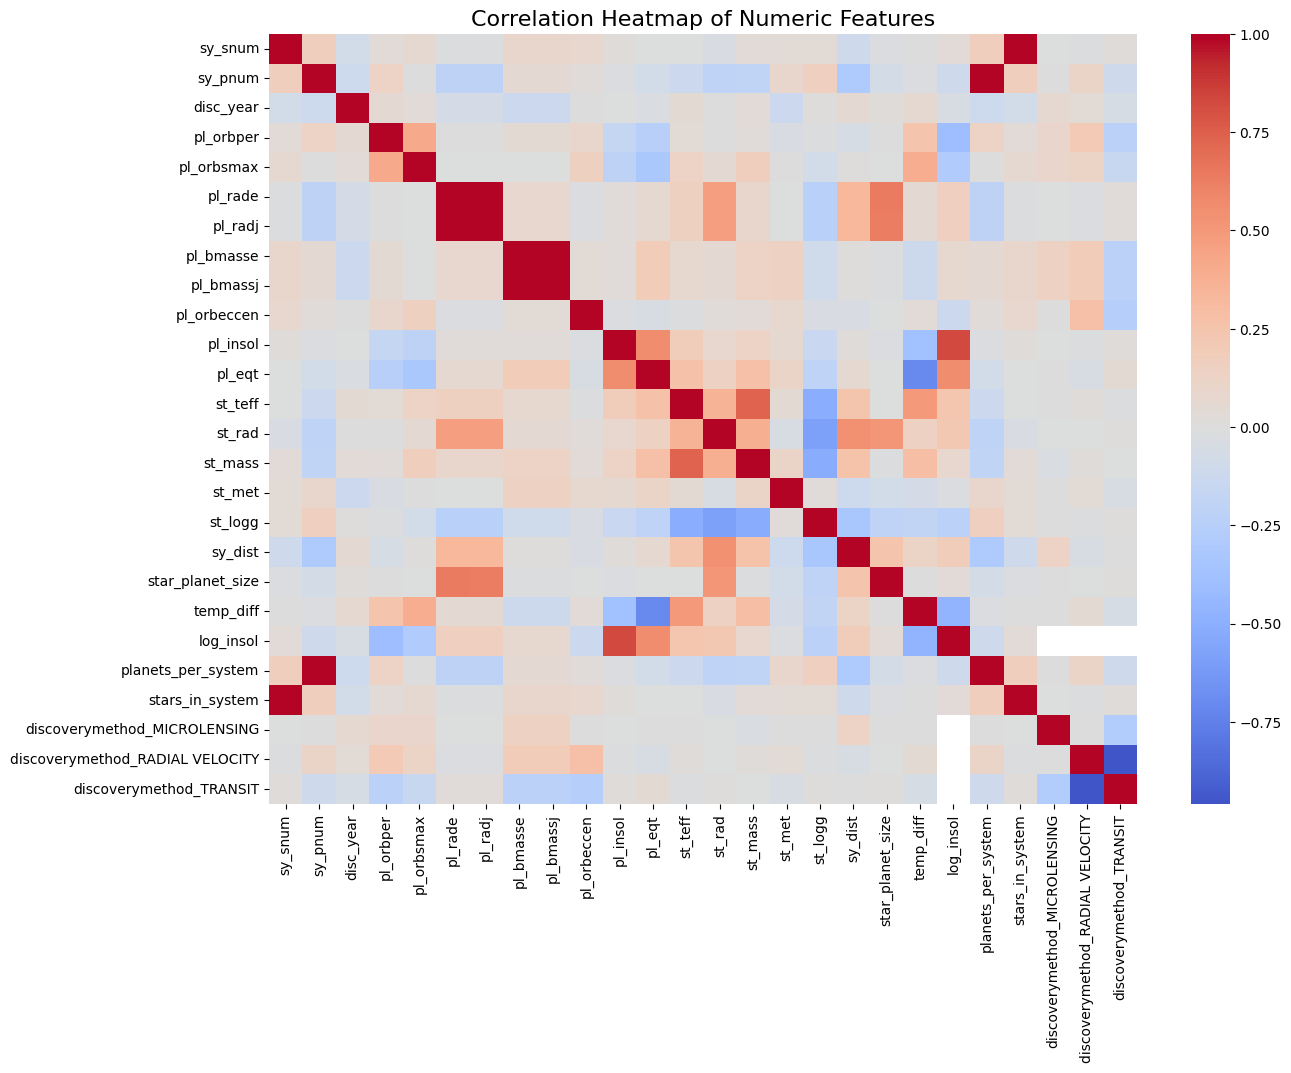

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
corr_matrix = df_encoded.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()

In [47]:
# Encode target temporarily for correlation check
df_corr = df_encoded.copy()
df_corr["target"] = (df_corr["disposition"] == "CONFIRMED").astype(int)

target_corr = df_corr.corr(numeric_only=True)["target"].sort_values(ascending=False)
print(target_corr.head(15))   # top positive correlations
print(target_corr.tail(15))   # top negative correlations

target                             1.000000
sy_pnum                            0.680103
planets_per_system                 0.680103
stars_in_system                    0.171810
sy_snum                            0.171810
st_logg                            0.141939
pl_bmasse                          0.139457
pl_bmassj                          0.139455
st_met                             0.105006
pl_orbeccen                        0.078991
pl_orbper                          0.065375
discoverymethod_RADIAL VELOCITY    0.064924
pl_insol                           0.057424
pl_eqt                             0.045012
pl_orbsmax                         0.025474
Name: target, dtype: float64
pl_insol                        0.057424
pl_eqt                          0.045012
pl_orbsmax                      0.025474
discoverymethod_MICROLENSING    0.019095
discoverymethod_TRANSIT        -0.067705
log_insol                      -0.068887
st_teff                        -0.076591
disc_year               

In [48]:
df_encoded.shape

(4004, 27)

In [49]:
df_encoded.columns.to_list()

['disposition',
 'sy_snum',
 'sy_pnum',
 'disc_year',
 'pl_orbper',
 'pl_orbsmax',
 'pl_rade',
 'pl_radj',
 'pl_bmasse',
 'pl_bmassj',
 'pl_orbeccen',
 'pl_insol',
 'pl_eqt',
 'st_teff',
 'st_rad',
 'st_mass',
 'st_met',
 'st_logg',
 'sy_dist',
 'star_planet_size',
 'temp_diff',
 'log_insol',
 'planets_per_system',
 'stars_in_system',
 'discoverymethod_MICROLENSING',
 'discoverymethod_RADIAL VELOCITY',
 'discoverymethod_TRANSIT']

# Model Training (XGBoost)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

In [51]:
# Create binary target
df_encoded["target"] = df_encoded["disposition"].apply(lambda x: 1 if x == "CONFIRMED" else 0)

# Features and target
X = df_encoded.drop(["disposition", "target"], axis=1)
y = df_encoded["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost for binary classification
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [52]:
# Predictions
y_pred = xgb_clf.predict(X_test)

In [53]:
print(y_pred[:10])  # first 10 predictions

[0 1 1 0 0 0 1 1 1 0]


In [54]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9975031210986267

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       338
           1       1.00      1.00      1.00       463

    accuracy                           1.00       801
   macro avg       1.00      1.00      1.00       801
weighted avg       1.00      1.00      1.00       801



## Saving Model (Overfitted)

In [55]:
import pickle

# Save
with open("xgb_exoplanet_model.pkl", "wb") as f:
    pickle.dump(xgb_clf, f)

# Load
# with open("xgb_exoplanet_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)


In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# 🔹 Train Decision Tree
dt_clf = DecisionTreeClassifier(
    max_depth=5,       # limit depth to avoid overfitting
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

from sklearn.impute import SimpleImputer

# Imputer for numeric features
imputer = SimpleImputer(strategy="median")  # or "mean"
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Fit Decision Tree on imputed data
dt_clf.fit(X_train_imputed, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [57]:
# 🔹 Predictions
y_pred_dt = dt_clf.predict(X_test_imputed)
y_pred_proba_dt = dt_clf.predict_proba(X_test_imputed)[:, 1]

In [58]:
# 🔹 Evaluation metrics
print("Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_dt))


Decision Tree Performance:
Accuracy: 0.9962546816479401
Precision: 0.9935622317596566
Recall: 1.0
F1 Score: 0.9967707212055974
ROC AUC: 0.9980318734264572


In [59]:

# 🔹 Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# 🔹 Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))


Confusion Matrix:
 [[335   3]
 [  0 463]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       338
           1       0.99      1.00      1.00       463

    accuracy                           1.00       801
   macro avg       1.00      1.00      1.00       801
weighted avg       1.00      1.00      1.00       801



## Decision Trees (Still overfitted)

In [60]:
import pickle

# Save model
with open("decision_tree_model.pkl", "wb") as f:
    pickle.dump(dt_clf, f)

print("Model saved as decision_tree_model.pkl using pickle")


# # Load model
# with open("decision_tree_model.pkl", "rb") as f:
#     dt_loaded = pickle.load(f)

# # Test prediction
# y_pred_loaded = dt_loaded.predict(X_test_imputed)
# print("Loaded model accuracy:", accuracy_score(y_test, y_pred_loaded))

Model saved as decision_tree_model.pkl using pickle


## Regularized Decision Trees

In [64]:
# Train Decision Tree (regularized)
dt_reg = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=30,
    min_samples_leaf=15,
    max_features="sqrt",
    random_state=42
)

dt_reg.fit(X_train_imputed, y_train)

# Predictions
y_pred_train = dt_reg.predict(X_train_imputed)
y_pred_test = dt_reg.predict(X_test_imputed)

# Training performance
print("=== Training Performance ===")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train))
print("Recall:", recall_score(y_train, y_pred_train))
print("F1 Score:", f1_score(y_train, y_pred_train))

# Test performance
print("\n=== Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))


=== Training Performance ===
Accuracy: 0.9884483296909148
Precision: 0.980412916887242
Recall: 1.0
F1 Score: 0.9901095963646084

=== Test Performance ===
Accuracy: 0.9962546816479401
Precision: 0.9935622317596566
Recall: 1.0
F1 Score: 0.9967707212055974


## Cross Validation

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Pipeline: Imputer + Decision Tree
dt_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs
    ("clf", DecisionTreeClassifier(
        max_depth=4,
        min_samples_split=30,
        min_samples_leaf=15,
        max_features="sqrt",
        random_state=42
    ))
])

# Stratified 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation with accuracy
scores = cross_val_score(dt_pipeline, X, y, cv=cv, scoring="accuracy")

print("Cross-Validation Accuracies:", scores)
print("Mean Accuracy:", np.mean(scores))
print("Std Deviation:", np.std(scores))


Cross-Validation Accuracies: [0.99001248 0.99001248 0.98751561 0.99126092 0.99125   ]
Mean Accuracy: 0.990010299625468
Std Deviation: 0.0013656080197416902


In [68]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Pipeline: Imputer + Decision Tree
dt_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", DecisionTreeClassifier(
        max_depth=4,
        min_samples_split=30,
        min_samples_leaf=15,
        max_features="sqrt",
        random_state=42
    ))
])

# Stratified 5-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define multiple scoring metrics
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1"
}

# Run cross-validation
results = cross_validate(dt_pipeline, X, y, cv=cv, scoring=scoring)

# Print fold-wise results
for i in range(cv.get_n_splits()):
    print(f"\n=== Fold {i+1} ===")
    print("Accuracy :", results["test_accuracy"][i])
    print("Precision:", results["test_precision"][i])
    print("Recall   :", results["test_recall"][i])
    print("F1 Score :", results["test_f1"][i])

# Print average performance across folds
print("\n=== Cross-Validation Averages ===")
print("Mean Accuracy :", np.mean(results["test_accuracy"]))
print("Mean Precision:", np.mean(results["test_precision"]))
print("Mean Recall   :", np.mean(results["test_recall"]))
print("Mean F1 Score :", np.mean(results["test_f1"]))



=== Fold 1 ===
Accuracy : 0.9900124843945068
Precision: 0.9830148619957537
Recall   : 1.0
F1 Score : 0.9914346895074947

=== Fold 2 ===
Accuracy : 0.9900124843945068
Precision: 0.9830148619957537
Recall   : 1.0
F1 Score : 0.9914346895074947

=== Fold 3 ===
Accuracy : 0.9875156054931336
Precision: 0.9788583509513742
Recall   : 1.0
F1 Score : 0.9893162393162394

=== Fold 4 ===
Accuracy : 0.9912609238451935
Precision: 0.9851063829787234
Recall   : 1.0
F1 Score : 0.992497320471597

=== Fold 5 ===
Accuracy : 0.99125
Precision: 0.9851063829787234
Recall   : 1.0
F1 Score : 0.992497320471597

=== Cross-Validation Averages ===
Mean Accuracy : 0.990010299625468
Mean Precision: 0.9830201681800658
Mean Recall   : 1.0
Mean F1 Score : 0.9914360518548845


In [69]:
import pickle

# First, fit your pipeline on the entire dataset
dt_pipeline.fit(X, y)

# Save the trained pipeline to a pickle file
with open("decision_tree_pipeline.pkl", "wb") as f:
    pickle.dump(dt_pipeline, f)

print("Model saved as 'decision_tree_pipeline.pkl'")



# with open("decision_tree_pipeline.pkl", "rb") as f:
#     loaded_pipeline = pickle.load(f)

# # Example prediction
# y_pred = loaded_pipeline.predict(X_test)


Model saved as 'decision_tree_pipeline.pkl'
